In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings

# Ignorer les warnings de dépréciation pour un code plus propre
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importation de Plotly pour la visualisation des données
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Définir une palette de couleurs personnalisée pour Plotly
pio.templates["jedha"] = go.layout.Template(
    layout=go.Layout(
        colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
    )
)

# Spécifier le renderer par défaut pour les graphiques
pio.renderers.default = "svg"

In [6]:
from sklearn import datasets
data = datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False)
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [7]:
print(data.data.shape, data.target.shape)
print(data.feature_names[0:6])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']


In [8]:
# Afficher les valeurs cibles (target) :
print("Target values:")
print(data['target'])  # Accès aux valeurs cibles via le dictionnaire

Target values:
[4.526 3.585 3.521 ... 0.923 0.847 0.894]


In [9]:
# Afficher les noms des caractéristiques (features) :
print("Feature names:")
print(data["feature_names"])  # Accès aux noms des caractéristiques

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [10]:
# Créer un DataFrame à partir des caractéristiques du dataset
dataset = pd.DataFrame(data=data["data"], columns=data["feature_names"])

# Ajouter une colonne 'Price' avec les valeurs cibles
dataset['Price'] = data["target"]

# Afficher les premières lignes du dataset
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


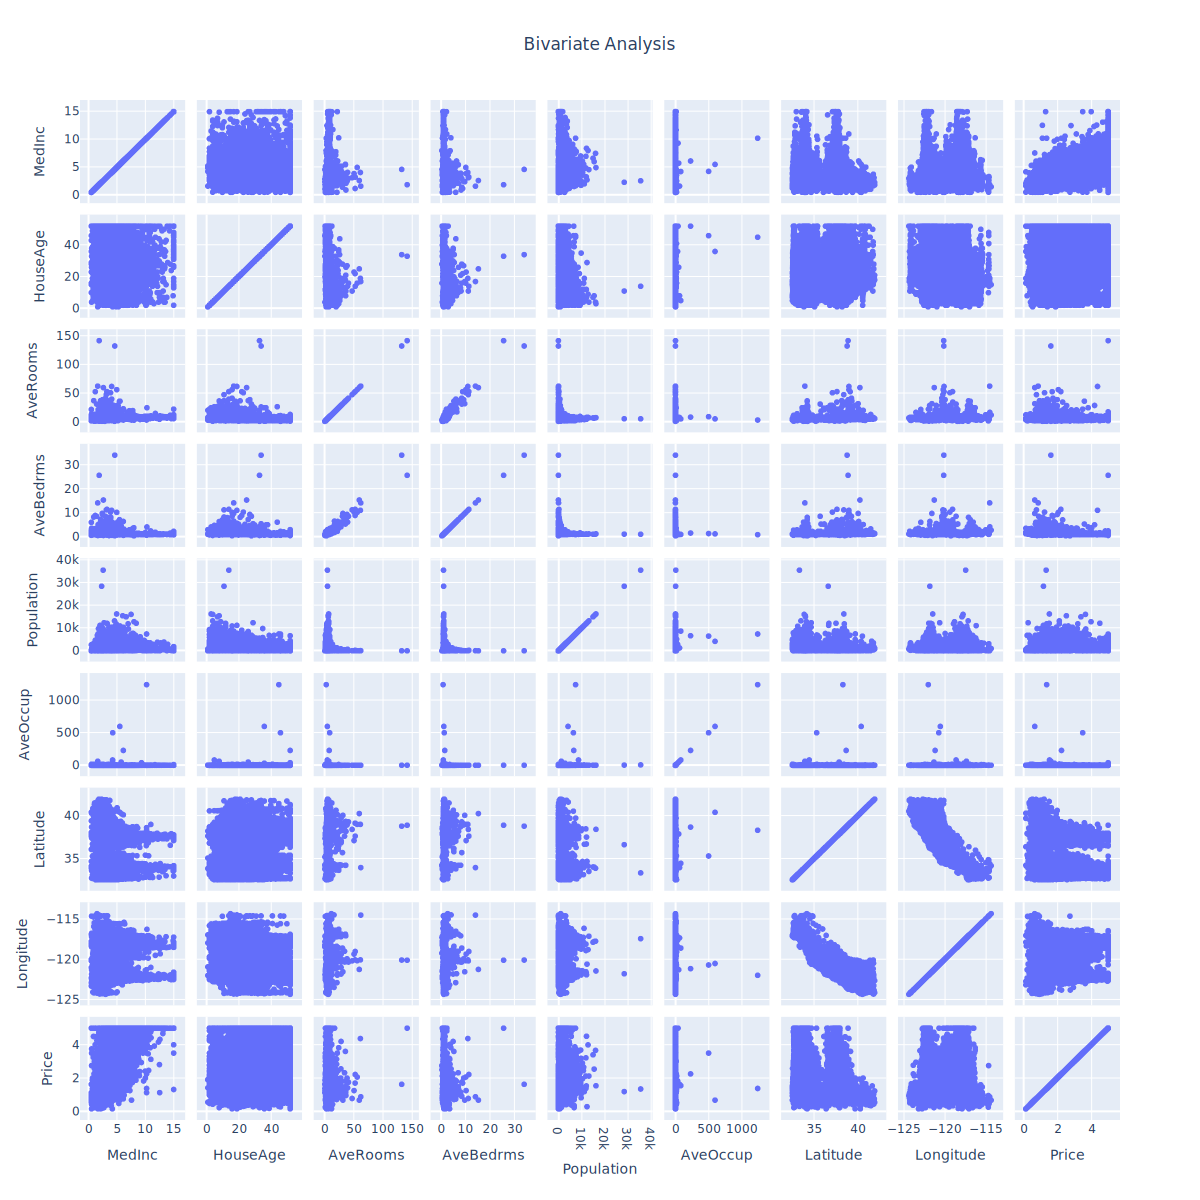

In [11]:
# Visualiser les dépendances entre paires avec un scatter matrix
fig = px.scatter_matrix(
    dataset,
    title="Bivariate Analysis"  # Ajout du titre directement ici
)

# Mettre à jour la mise en page du graphique
fig.update_layout(
    title_x=0.5,  # Centrer le titre
    showlegend=False,  # Désactiver la légende
    autosize=False,  # Désactiver l'ajustement automatique
    height=1200,  # Définir la hauteur
    width=1200    # Définir la largeur
)

# Afficher le graphique
fig.show()

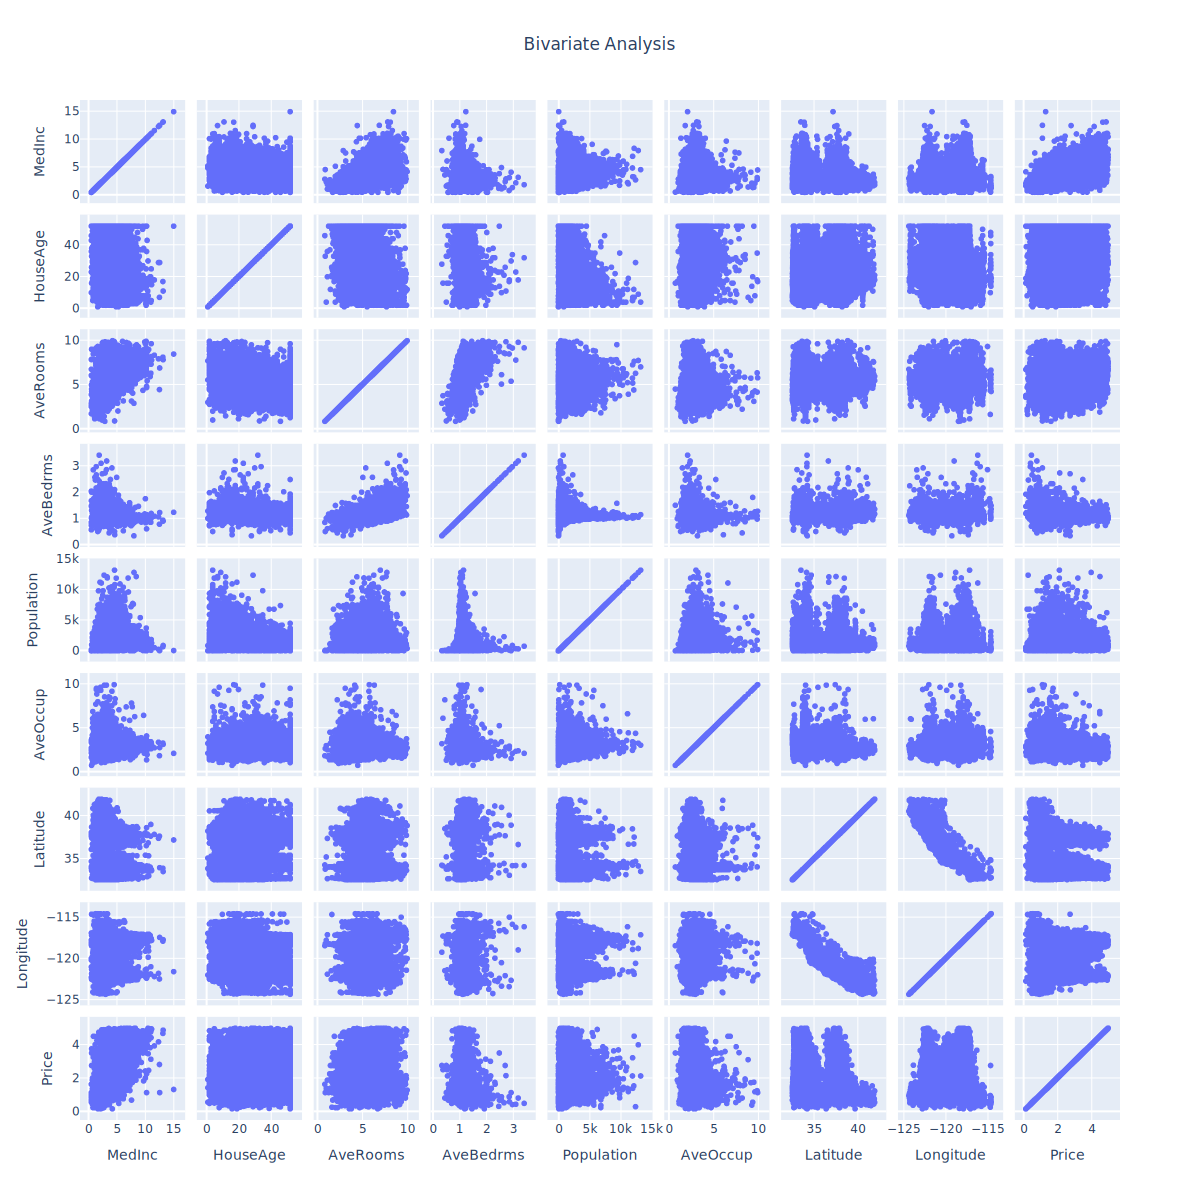

In [12]:
# Appliquer un masque pour filtrer les données selon plusieurs conditions
mask = (
    (dataset['AveRooms'] < 10) &
    (dataset['AveBedrms'] < 10) &
    (dataset['Population'] < 15000) &
    (dataset['AveOccup'] < 10) &
    (dataset['Price'] < 5)
)

# Filtrer le dataset en fonction du masque
filtered_dataset = dataset.loc[mask]

# Visualiser les dépendances entre paires avec un scatter matrix
fig = px.scatter_matrix(
    filtered_dataset,
    title="Bivariate Analysis"
)

# Mettre à jour la mise en page du graphique
fig.update_layout(
    title_x=0.5,  # Centrer le titre
    showlegend=False,  # Masquer la légende
    autosize=False,  # Désactiver l'ajustement automatique
    height=1200,  # Hauteur définie
    width=1200    # Largeur définie
)

# Afficher le graphique
fig.show()

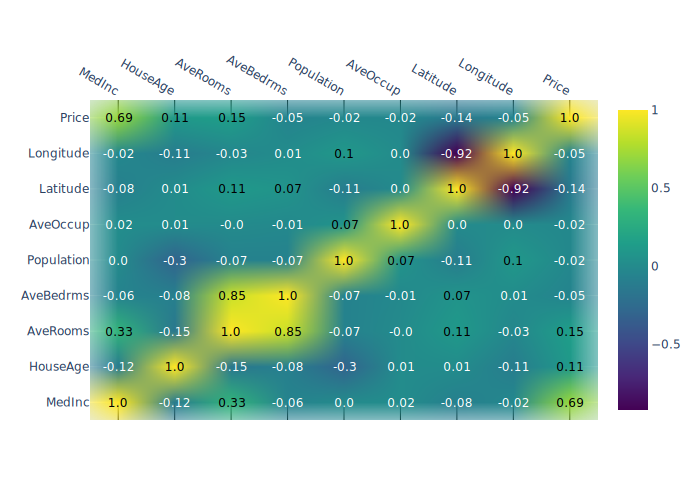

In [13]:
# Calculer la matrice de corrélation et arrondir les valeurs à 2 décimales
corr_matrix = dataset.corr().round(2)

# Importer Plotly pour créer la heatmap annotée
import plotly.figure_factory as ff

# Créer la heatmap annotée avec les valeurs de corrélation
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,  # Valeurs de corrélation
    x=corr_matrix.columns.tolist(),  # Noms des colonnes (axes x)
    y=corr_matrix.index.tolist(),  # Noms des lignes (axes y)
    colorscale='Viridis',  # Choix de la palette de couleurs
    annotation_text=corr_matrix.values,  # Affichage des annotations (valeurs)
    showscale=True  # Afficher la barre de couleurs
)

# Afficher la heatmap
fig.show()

# Baseline Model

In [14]:
# Séparation de la variable cible Y des features X
print("Séparation des labels des features...")

features_list = ["MedInc"]
target_variable = "Price"

# Extraction des features et de la variable cible
X = dataset[features_list]
Y = dataset[target_variable]

print("...Fini.\n")

# Affichage des premières lignes de Y et X
print('Y (Target Variable - Price) :')
print(Y.head(), "\n")

print('X (Feature - Median Income) :')
print(X.head())

Séparation des labels des features...
...Fini.

Y (Target Variable - Price) :
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64 

X (Feature - Median Income) :
   MedInc
0  8.3252
1  8.3014
2  7.2574
3  5.6431
4  3.8462


In [15]:
# Diviser le dataset en ensembles d'entraînement et de test
print("Division en ensembles d'entraînement et de test...")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("...Fini.\n")

# Affichage de la taille des ensembles d'entraînement et de test
print(f"Dimensions de X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}, Y_test: {Y_test.shape}\n")

Division en ensembles d'entraînement et de test...
...Fini.

Dimensions de X_train: (16512, 1), Y_train: (16512,)
Dimensions de X_test: (4128, 1), Y_test: (4128,)



In [16]:
# Basic stats
print(f"Number of rows: {dataset.shape[0]}, Number of columns: {dataset.shape[1]}")
print(dataset.shape)

# Affichage du dataset
print("Display of dataset: ")
display(dataset.head())
print()

# Statistiques de base
print("Basic statistics: ")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

# Pourcentage des valeurs manquantes
print("Percentage of missing values: ")
missing_values = 100 * dataset.isnull().sum() / dataset.shape[0]
display(missing_values)

Number of rows: 20640, Number of columns: 9
(20640, 9)
Display of dataset: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Basic statistics: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



Percentage of missing values: 


MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
Price         0.0
dtype: float64

In [17]:
# Afficher les premières lignes de X_train avant le prétraitement
print("Preprocessing X_train...\n")
print(X_train.head(), "\n")

# Standardiser les données avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Enregistrer le résultat dans une nouvelle variable pour plus de clarté

# Confirmation de la fin du processus de standardisation
print("...Done! X_train has been scaled.\n")

# Afficher les 5 premières lignes de X_train après transformation
print(X_train_scaled[:5, :])  # X_train_scaled est maintenant un tableau numpy

Preprocessing X_train...

       MedInc
12069  4.2386
15925  4.3898
11162  3.9333
4904   1.4653
4683   3.1765 

...Done! X_train has been scaled.

[[ 0.19001247]
 [ 0.26931072]
 [ 0.02989505]
 [-1.26447048]
 [-0.36701574]]


In [18]:
# Afficher les premières lignes de X_test avant le prétraitement
print("Preprocessing X_test...\n")
print(X_test.head(), "\n")

# Appliquer la transformation (sans réajustement) sur X_test
X_test_scaled = scaler.transform(X_test)  # Utilisation de transform() sans refit

# Confirmation de la fin du processus de transformation
print("...Done! X_test has been scaled.\n")

# Afficher les 5 premières lignes de X_test après transformation
print(X_test_scaled[:5, :])  # X_test_scaled est maintenant un tableau numpy

Preprocessing X_test...

       MedInc
14740  4.1518
10101  5.7796
20566  4.3487
2670   2.4511
15709  5.0049 

...Done! X_test has been scaled.

[[ 0.14448941]
 [ 0.99820424]
 [ 0.24775544]
 [-0.74745851]
 [ 0.59190563]]


In [20]:
# Entraîner le modèle de régression linéaire
print("Training the linear regression model...\n")
regressor = LinearRegression()

# Ajuster (fit) le modèle sur les données d'entraînement
regressor.fit(X_train_scaled, Y_train)

# Confirmation de la fin de l'entraînement
print("Model training completed.\n")

Training the linear regression model...

Model training completed.



In [21]:
# Calculer et afficher les scores R² pour les ensembles d'entraînement et de test
train_score = regressor.score(X_train_scaled, Y_train)
test_score = regressor.score(X_test_scaled, Y_test)

print(f"R² score on training set: {train_score:.4f}")
print(f"R² score on test set: {test_score:.4f}")

R² score on training set: 0.4799
R² score on test set: 0.4467


In [22]:
# Faire des prédictions sur l'ensemble d'entraînement
print("Making predictions on the training set...\n")
Y_train_pred = regressor.predict(X_train_scaled)
print("Predictions completed.\n")

# Afficher les prédictions sur l'ensemble d'entraînement
print("Predictions on training set:\n", Y_train_pred, "\n")

Making predictions on the training set...

Predictions completed.

Predictions on training set:
 [2.22478224 2.28833489 2.096458   ... 1.7872693  2.81024844 1.02669704] 



In [23]:
# Faire des prédictions sur l'ensemble de test
print("Making predictions on the test set...\n")
Y_test_pred = regressor.predict(X_test_scaled)
print("Predictions completed.\n")

# Afficher les prédictions sur l'ensemble de test
print("Predictions on test set:\n", Y_test_pred, "\n")

Making predictions on the test set...

Predictions completed.

Predictions on test set:
 [2.18829831 2.87249809 2.27105966 ... 1.78937091 3.02549522 1.84397071] 



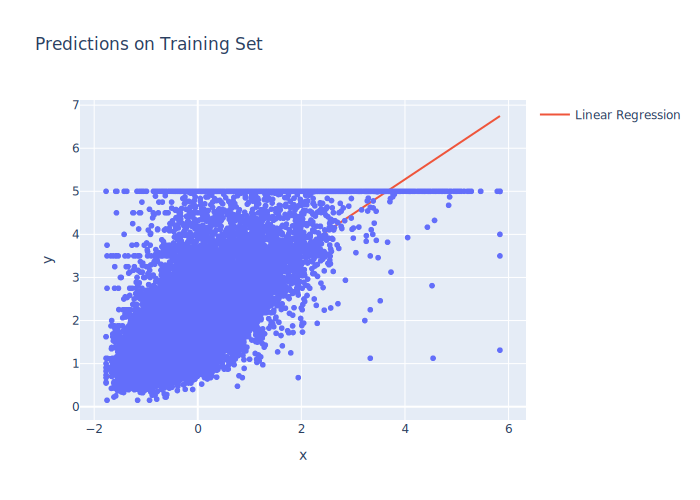

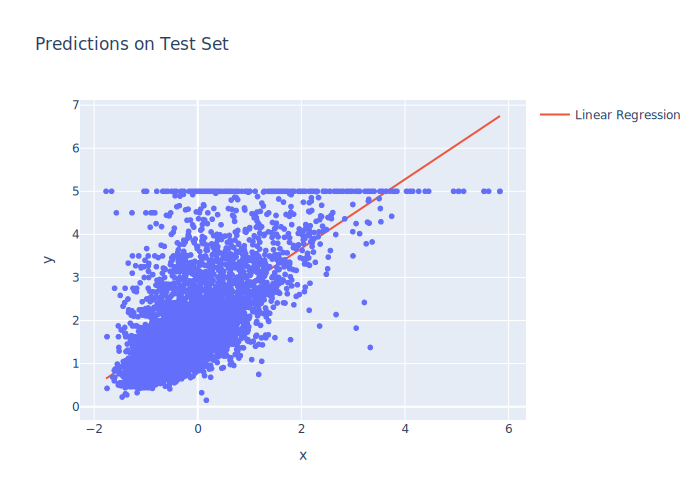

In [24]:
# Visualiser les prédictions sur l'ensemble d'entraînement
fig_train = px.scatter(
    x=X_train_scaled.flatten().tolist(),  # Utiliser X_train_scaled pour la cohérence
    y=Y_train,
    title="Predictions on Training Set"
)
fig_train.add_trace(go.Scatter(
    x=X_train_scaled.flatten().tolist(),
    y=Y_train_pred,
    mode='lines',
    name="Linear Regression"
))
fig_train.show()

# Visualiser les prédictions sur l'ensemble de test
fig_test = px.scatter(
    x=X_test_scaled.flatten().tolist(),  # Utiliser X_test_scaled pour la cohérence
    y=Y_test,
    title="Predictions on Test Set"
)
fig_test.add_trace(go.Scatter(
    x=X_test_scaled.flatten().tolist(),
    y=Y_test_pred,
    mode='lines',
    name="Linear Regression"
))
fig_test.show()

# Multivariate Model

In [25]:
# Séparer la variable cible Y des caractéristiques X
print("Separating target variable from features...\n")

target_variable = "Price"

# X contient toutes les caractéristiques sauf la variable cible
X = dataset.drop(columns=[target_variable])

# Y contient uniquement la variable cible
Y = dataset[target_variable]

print("Separation completed.\n")

# Afficher les premières lignes de Y
print('Target variable (Y):\n', Y.head(), "\n")

# Afficher les premières lignes de X
print('Features (X):')
print(X.head())

Separating target variable from features...

Separation completed.

Target variable (Y):
 0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Price, dtype: float64 

Features (X):
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [28]:
# Diviser le dataset en ensembles d'entraînement et de test
print("Splitting the dataset into training and test sets...\n")

# Effectuer la division en ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Splitting completed.\n")

# Afficher les dimensions des ensembles d'entraînement et de test
print(f"Training set dimensions: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Test set dimensions: X_test: {X_test.shape}, Y_test: {Y_test.shape}\n")

Splitting the dataset into training and test sets...

Splitting completed.

Training set dimensions: X_train: (16512, 8), Y_train: (16512,)
Test set dimensions: X_test: (4128, 8), Y_test: (4128,)



In [29]:
# Statistiques de base sur le dataset
print(f"Dataset dimensions: {dataset.shape[0]} rows, {dataset.shape[1]} columns\n")

# Affichage des premières lignes du dataset
print("First few rows of the dataset:")
display(dataset.head())
print()

# Affichage des statistiques de base
print("Basic statistics of the dataset:")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

# Calcul et affichage du pourcentage de valeurs manquantes
print("Percentage of missing values per column:")
missing_values = 100 * dataset.isnull().sum() / dataset.shape[0]
display(missing_values)
print()

Dataset dimensions: 20640 rows, 9 columns

First few rows of the dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Basic statistics of the dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



Percentage of missing values per column:


MedInc        0.0
HouseAge      0.0
AveRooms      0.0
AveBedrms     0.0
Population    0.0
AveOccup      0.0
Latitude      0.0
Longitude     0.0
Price         0.0
dtype: float64

continuer à We have only numeric features with no missing values, so here the preprocessing is very simple: we just want to standardize all the columns!